In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import altair as alt

In [3]:
# Read dataset
use_cols = [
    'measured log(solubility:mol/L)', 'SMILES'
]
data = pd.read_csv('delaney.csv', usecols=use_cols)
print(data.shape)
print(data.head(20))

(1145, 2)
    measured log(solubility:mol/L)                        SMILES
0                            -2.18                ClCC(Cl)(Cl)Cl
1                            -2.00                  CC(Cl)(Cl)Cl
2                            -1.74                ClC(Cl)C(Cl)Cl
3                            -1.48                    ClCC(Cl)Cl
4                            -2.03  CN1C=NC2=C1C(=O)N(C(=O)N2C)C
5                            -3.04           FC(F)(Cl)C(F)(Cl)Cl
6                            -1.29                      CC(Cl)Cl
7                            -1.64                     ClC(=C)Cl
8                            -0.43                    CCOC(C)OCC
9                            -4.57          Clc1ccc(Cl)c(Cl)c1Cl
10                           -4.37                C1CCc2ccccc2C1
11                           -4.63        Clc1cc(Cl)c(Cl)c(Cl)c1
12                           -4.00              Clc1cccc(Cl)c1Cl
13                           -3.20                 Cc1cccc(C)c1C
14             

In [6]:
# Make target label using threshold
drug_quality = []
for val in data['measured log(solubility:mol/L)']:
    if abs(val) < abs(data['measured log(solubility:mol/L)'].mean()):
        drug_quality.append(0)
    else:
        drug_quality.append(1)

data['Quality'] = drug_quality

print(data['Quality'].value_counts())
data.head(10)

0    607
1    538
Name: Quality, dtype: int64


,measured log(solubility:mol/L),SMILES,Quality
0,-2.18,ClCC(Cl)(Cl)Cl,0
1,-2.00,CC(Cl)(Cl)Cl,0
2,-1.74,ClC(Cl)C(Cl)Cl,0
3,-1.48,ClCC(Cl)Cl,0
4,-2.03,CN1C=NC2=C1C(=O)N(C(=O)N2C)C,0
5,-3.04,FC(F)(Cl)C(F)(Cl)Cl,0
6,-1.29,CC(Cl)Cl,0
7,-1.64,ClC(=C)Cl,0
8,-0.43,CCOC(C)OCC,0
9,-4.57,Clc1ccc(Cl)c(Cl)c1Cl,1


In [8]:
# Convert SMILES to RDKit object
mol_list= []
for element in data.SMILES:
  mol = Chem.MolFromSmiles(element)
  mol_list.append(mol)

  # Calculate molecular descriptors from SMILES
'''
cLogP (Octanol-water partition coefficient)
MW (Molecular weight)
RB (Number of rotatable bonds)
AP (Aromatic proportion = number of aromatic atoms / number of heavy atoms)
'''

def generate_MolDes(smiles, verbose=False):
    '''
    Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation
                    https://towardsdatascience.com/how-to-use-machine-learning-for-drug-discovery-1ccb5fdf81ad#885b
     '''
    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:

        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_MolWt = Descriptors.MolWt(mol)
        desc_NumRotatableBonds = Descriptors.NumRotatableBonds(mol)

        row = np.array([desc_MolLogP,
                        desc_MolWt,
                        desc_NumRotatableBonds])

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["MolLogP","MolWt","NumRotatableBonds"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors

def AromaticAtoms(m):
  aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
  aa_count = []
  for i in aromatic_atoms:
    if i==True:
      aa_count.append(1)
  sum_aa_count = sum(aa_count)
  return sum_aa_count

In [9]:
# Calculate cLogP,MW,RB
desc_df = generate_MolDes(data.SMILES)
# Calculate AP
desc_AromaticProportion = [AromaticAtoms(element)/Descriptors.HeavyAtomCount(element) for element in mol_list]
desc_df['Aromatic proportion'] = desc_AromaticProportion
desc_df.head(10)

,MolLogP,MolWt,NumRotatableBonds,Aromatic proportion
0,2.5954,167.850,0.0,0.000000
1,2.3765,133.405,0.0,0.000000
2,2.5938,167.850,1.0,0.000000
3,2.0289,133.405,1.0,0.000000
4,-1.0293,194.194,0.0,0.642857
5,2.9189,187.375,1.0,0.000000
6,1.8100,98.960,0.0,0.000000
7,1.9352,96.944,0.0,0.000000
8,1.4054,118.176,4.0,0.000000
9,4.3002,215.894,0.0,0.600000


In [10]:
mnscaler = MinMaxScaler()
X = mnscaler.fit_transform(desc_df)
Y = data['Quality'].to_numpy()


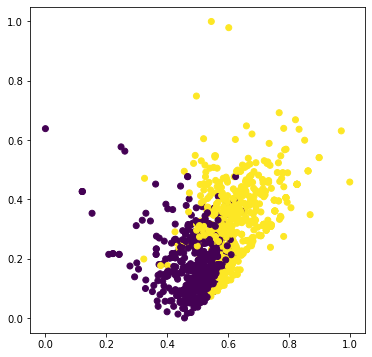

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize = (6, 6))
plt.scatter(X[:, 0], X[:, 1], c = Y)
plt.show()

In [12]:
# Perceptron Algo
# Inspired from https://pabloinsente.github.io/the-perceptron

def random_weights(X, random_state: int):
    rand = np.random.RandomState(random_state)
    w = rand.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
    return w

def net_input(X, w):
    return np.dot(X, w[1:]) + w[0]

def predict(X, w):
    return np.where(net_input(X, w) >= 0.0, 1, 0)

def fit(X, y, eta=0.001, n_iter=100):
    errors = []
    accuracies = []
    w = random_weights(X, random_state=42)
    for exemplar in range(n_iter):
        error = 0
        y_pred = []
        for xi, target in zip(X, y):
            predicted = predict(xi, w)
            delta = eta * (target - predicted)
            w[1:] += delta * xi
            w[0] += delta
            error += int(delta != 0.0)
            y_pred.append(predicted)
        errors.append(error)
        accuracies.append(accuracy_score(y, y_pred))
        print('>epoch=%d,error=%.3f' % (exemplar, error))
    return w, errors, accuracies

In [13]:
w, errors,accuracies = fit(X, Y, eta=0.01, n_iter=50)

error_df = pd.DataFrame({'error':errors, 'time-step': np.arange(0, len(errors))})
accuracy_df = pd.DataFrame({'accuracy':accuracies, 'time-step': np.arange(0, len(errors))})

alt.Chart(error_df).mark_line().encode(
    x="time-step", y="error"
).properties(
    title='Epoch vs Error'
)


>epoch=0,error=312.000
>epoch=1,error=234.000
>epoch=2,error=213.000
>epoch=3,error=218.000
>epoch=4,error=217.000
>epoch=5,error=208.000
>epoch=6,error=187.000
>epoch=7,error=208.000
>epoch=8,error=202.000
>epoch=9,error=190.000
>epoch=10,error=188.000
>epoch=11,error=190.000
>epoch=12,error=188.000
>epoch=13,error=190.000
>epoch=14,error=188.000
>epoch=15,error=182.000
>epoch=16,error=200.000
>epoch=17,error=194.000
>epoch=18,error=190.000
>epoch=19,error=190.000
>epoch=20,error=188.000
>epoch=21,error=188.000
>epoch=22,error=190.000
>epoch=23,error=186.000
>epoch=24,error=188.000
>epoch=25,error=192.000
>epoch=26,error=188.000
>epoch=27,error=192.000
>epoch=28,error=186.000
>epoch=29,error=192.000
>epoch=30,error=194.000
>epoch=31,error=188.000
>epoch=32,error=186.000
>epoch=33,error=184.000
>epoch=34,error=196.000
>epoch=35,error=192.000
>epoch=36,error=188.000
>epoch=37,error=188.000
>epoch=38,error=196.000
>epoch=39,error=190.000
>epoch=40,error=186.000
>epoch=41,error=196.000
>e

alt.Chart(...)

In [14]:
alt.Chart(accuracy_df).mark_line().encode(
    x="time-step", y="accuracy"
).properties(
    title='Epoch vs accuracy'
)

alt.Chart(...)